motivation: tpus are suspended all the time, so curves are segmented

In [6]:
import json
import tensorflow as tf
import matplotlib.pyplot as plt

experiments_dict = {
    "clip": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/clip_bs16384_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_12lyr_07-25_1415",
    "contrastive_freeze_llm": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-T_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-18_0712",
    "contrastive_unfreeze_llm": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-20_2032",
    "contrastive_unfreeze_llm_half": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-21_1935",
    # "contrastive_unfreeze_llm_half_scratch": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-scratch-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-22_0327",
}

def get_metrics(experiment_name):
    ckpt_path = experiments_dict[experiment_name]
    metrics_path = f'{ckpt_path}/big_vision_metrics.txt'

    metrics = {}
    with tf.io.gfile.GFile(metrics_path, 'r') as f:
        lines = f.read().split('\n')
        for line in lines:
            if len(line) == 0:
                continue
            line_dict = json.loads(line)
            if line_dict['step'] % 1000 == 0:
                examples_seen = line_dict['examples_seen']
                inet = line_dict['z/0shot/imagenet2012_accuracy'] if 'z/0shot/imagenet2012_accuracy' in line_dict else None
                if inet is not None:
                    metrics[examples_seen] = inet
    return metrics

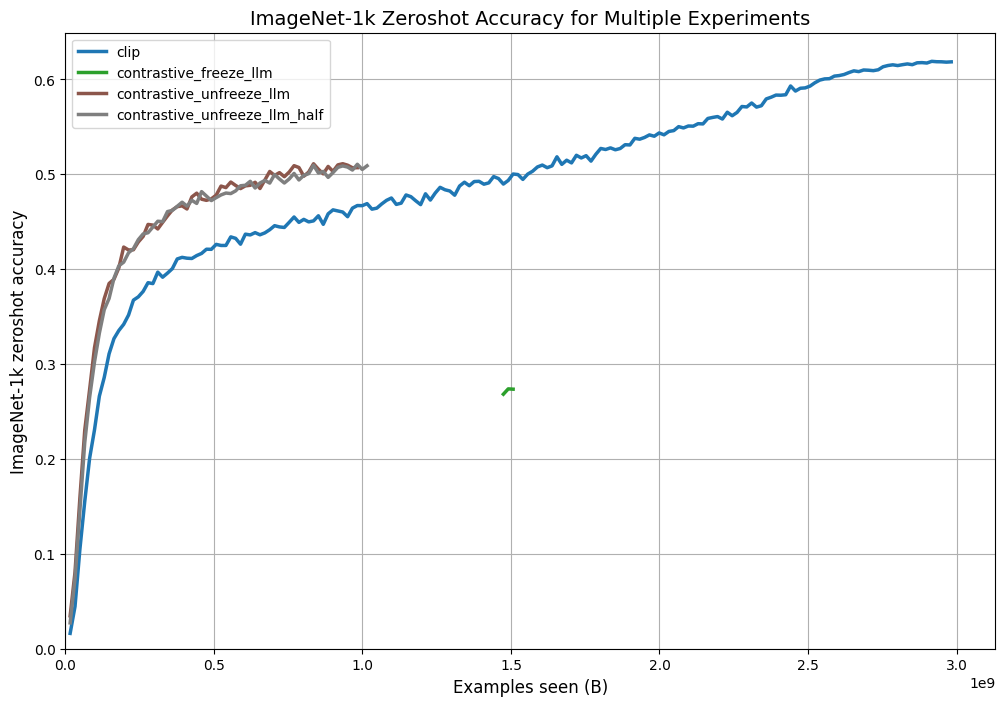

In [7]:
# Collect data for all experiments
all_metrics = {}
for experiment_name in experiments_dict.keys():
    all_metrics[experiment_name] = get_metrics(experiment_name)

# Plot all experiments on the same graph
plt.figure(figsize=(12, 8))
for experiment_name, metrics in all_metrics.items():
    plt.plot(list(metrics.keys()), list(metrics.values()), label=experiment_name, linewidth=2.5)  # Increased linewidth

plt.xlabel('Examples seen (B)', fontsize=12)
plt.ylabel('ImageNet-1k zeroshot accuracy', fontsize=12)
plt.xlim(0)
plt.ylim(0)
plt.legend(fontsize=10)
plt.title('ImageNet-1k Zeroshot Accuracy for Multiple Experiments', fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [8]:

# Print final metrics for each experiment
for experiment_name, metrics in all_metrics.items():
    final_metric = list(metrics.values())[-1]
    print(f"Final {experiment_name} metric: {final_metric}")

Final clip metric: 0.61852
Final contrastive_freeze_llm metric: 0.27354
Final contrastive_unfreeze_llm metric: 0.50698
Final contrastive_unfreeze_llm_half metric: 0.50898
